In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
plt.style.use("ggplot")
from sklearn import metrics
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import VotingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import BaggingClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import GradientBoostingClassifier

In [2]:
from churn_eda import clean_data
from onehotencoding import set_ohe
from random_forest import rand_forest

In [3]:
df_train = pd.read_csv('data/churn_train.csv')
df_test = pd.read_csv('data/churn_train.csv')
df_train = clean_data(df_train)
df_test = clean_data(df_test)
to_one_hot_encode = ['city', 'phone']
for each_hot in to_one_hot_encode:
    df_train = set_ohe(df_train, each_hot)
    df_test = set_ohe(df_test, each_hot)
    
y_train = df_train.pop('churn').values
y_test = df_test.pop('churn').values
X_train = df_train.values
X_test = df_test.values

In [4]:
df_train.head()

,avg_dist,avg_rating_by_driver,avg_rating_of_driver,avg_surge,surge_pct,trips_in_first_30_days,luxury_car_user,weekday_pct,avg_rating_of_driver_nan,avg_rating_by_driver_nan,days_since_signup,city: Winterfell,city: Astapor,phone: iPhone,phone: Android
0,6.94,5.0,5.000000,1.00,0.0,0,False,100.0,0,0,170,0.0,1.0,0.0,1.0
1,8.06,5.0,5.000000,1.00,0.0,2,True,0.0,0,0,157,0.0,1.0,0.0,1.0
2,21.50,4.0,4.601697,1.00,0.0,1,True,100.0,1,0,180,1.0,0.0,1.0,0.0
3,9.46,5.0,4.601697,2.75,100.0,1,False,100.0,1,0,173,1.0,0.0,0.0,1.0
4,13.77,5.0,4.601697,1.00,0.0,0,False,100.0,1,0,151,1.0,0.0,1.0,0.0


## Voting Classifier ##

In [5]:
log_clf = LogisticRegression(solver='liblinear')
rnd_clf = RandomForestClassifier(n_estimators=500, max_leaf_nodes=16, n_jobs=-1)
bag_clf = BaggingClassifier(
    DecisionTreeClassifier(), n_estimators=500,
    max_samples=100, bootstrap=True, n_jobs=-1)
gb_clf = GradientBoostingClassifier(learning_rate=0.1, 
                                   n_estimators=100, 
                                   min_samples_leaf=10,
                                  subsample=0.5)

voting_clf = VotingClassifier(
    estimators=[('lr', log_clf), ('rf', rnd_clf), ('bag', bag_clf), ('gb', gb_clf)],
    voting='soft')
voting_clf.fit(X_train, y_train)

y_pred = voting_clf.predict(X_test)

accuracy = voting_clf.score(X_test, y_test)
precision = metrics.precision_score(y_test, y_pred)
recall = metrics.recall_score(y_test, y_pred)

scorers = ['accuracy', 'precision', 'recall']
scores = [accuracy, precision, recall]

for each_scorer, each_score in zip(scorers, scores):
    print(f'{each_scorer}: {each_score:2.2f}')

accuracy: 0.78
precision: 0.78
recall: 0.90


In [12]:
len(y_pred)

40000

In [13]:
len(y_test)

40000

In [16]:
probabilities = voting_clf.predict_proba(X_test)[:, 1]

In [17]:
fpr, tpr, thresholds = metrics.roc_curve(y_test, probabilities)

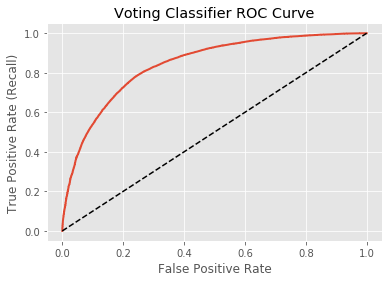

In [18]:
def plot_roc_curve(ax, fpr, tpr, label=None):
    ax.plot(fpr, tpr, linewidth=2, label=label)
    ax.plot([0,1], [0,1], 'k--')
    ax.set_title(f'{label} ROC Curve')
    ax.set_xlabel('False Positive Rate')
    ax.set_ylabel('True Positive Rate (Recall)')
fig, ax = plt.subplots()

plot_roc_curve(ax, fpr, tpr, 'Voting Classifier')

In [19]:
print(fpr)

[0.         0.         0.         ... 0.99953433 0.99953433 1.        ]


In [20]:
print(f'ROC AOC: {metrics.roc_auc_score(y_test, y_pred):2.2f}')

ROC AOC: 0.74
